In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm import tqdm_notebook
from fastai.vision import *
from fastai.metrics import error_rate

from preparation import get_logos, get_nr2classname_dict
nr2c = get_nr2classname_dict()
c2nr = {a:int(aa) for aa,a in nr2c.items()}
logos = get_logos()

In [10]:
def create_masks(logos):
    for lg in tqdm_notebook(logos):
        im = open_image(lg.path)
        if lg.logo:
            mask = torch.zeros(1,im.shape[1],im.shape[2])
            for a in lg.ann:
                m = open_mask(a.mask).data                
                m[m==255] = c2nr[ a.c ] # cannot be 0

                available_mask = (mask == 0).float()
                new_mask = available_mask * m.float()
                mask += new_mask
        else:
            mask = torch.zeros(1,im.shape[1],im.shape[2])
        
        mask = mask.permute(1,2,0).numpy()[:,:,0].astype(np.uint8) # (h,w) shape
        PIL.Image.fromarray(mask).save(str(lg.path)[:-4] + '.mask.png')

# create_masks(logos)
name2mask = {lg.path.name:str(lg.path)[:-4] + '.mask.png' for lg in logos}
classes = [nr2c[i] for i in range(48)]
classes

['no-logo',
 'HP',
 'adidas_symbol',
 'adidas_text',
 'aldi',
 'apple',
 'becks_symbol',
 'becks_text',
 'bmw',
 'carlsberg_symbol',
 'carlsberg_text',
 'chimay_symbol',
 'chimay_text',
 'cocacola',
 'corona_symbol',
 'corona_text',
 'dhl',
 'erdinger_symbol',
 'erdinger_text',
 'esso_symbol',
 'esso_text',
 'fedex',
 'ferrari',
 'ford',
 'fosters_symbol',
 'fosters_text',
 'google',
 'guinness_symbol',
 'guinness_text',
 'heineken',
 'milka',
 'nvidia_symbol',
 'nvidia_text',
 'paulaner_symbol',
 'paulaner_text',
 'pepsi_symbol',
 'pepsi_text',
 'rittersport',
 'shell',
 'singha_symbol',
 'singha_text',
 'starbucks',
 'stellaartois_symbol',
 'stellaartois_text',
 'texaco',
 'tsingtao_symbol',
 'tsingtao_text',
 'ups']

In [11]:
len(classes)

48

In [12]:
files = [x.path for x in logos if x.logo == True]
name2test = { x.path.name:x.test for x in logos }

tfms = get_transforms(do_flip=False)

data = (SegmentationItemList(files)
            .split_by_valid_func(lambda x: name2test[ x.name ])
            .label_from_func(lambda x: name2mask[ x.name ], classes=classes)
            .transform(tfms, size=(224,224), tfm_y=True)
            .databunch(bs=4, num_workers=4)
            .normalize(imagenet_stats)
       )

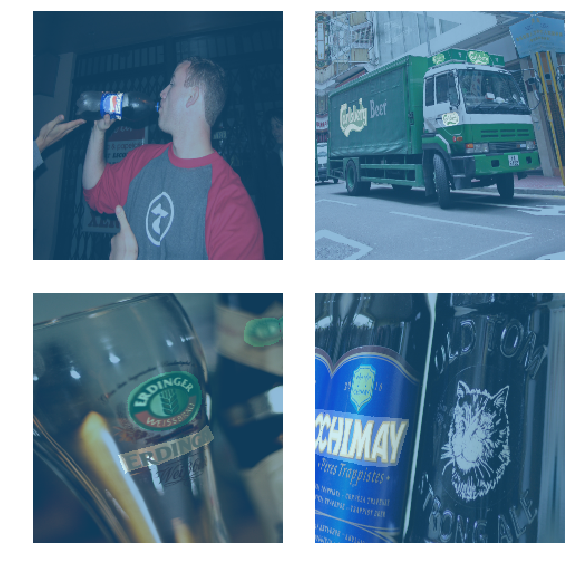

In [13]:
data.show_batch()

In [17]:
valid_dl = data.dl(ds_type=DatasetType.Valid)
for i,(x,y) in enumerate(valid_dl):
    print(x.shape, y.shape, y.unique())
    if i > 0: break

torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224]) tensor([ 0,  1, 31, 32, 38, 41], device='cuda:0')
torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 224, 224]) tensor([ 0,  1, 29, 33, 34, 42, 43], device='cuda:0')


In [18]:
def acc_camvid(y_pred, y_true):
    y_true = y_true.squeeze(1)
    mask = y_true != c2nr['no-logo']
    return (y_pred.argmax(dim=1)[mask]==y_true[mask]).float().mean()

learn = unet_learner(data, models.resnet34, metrics=[acc_camvid]) # , wd=wd, bottle=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-05


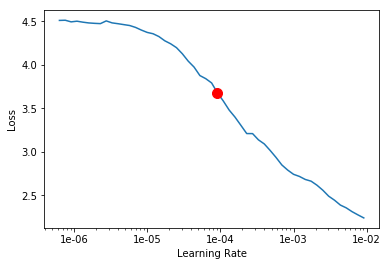

In [19]:
lr_find(learn)
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(4, max_lr=1e-4)

epoch,train_loss,valid_loss,acc_camvid
1,0.679362,0.586819,0.000606
2,0.542953,0.452158,0.016486
3,0.419496,0.426585,0.058450
4,0.386605,0.409538,0.093079


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06


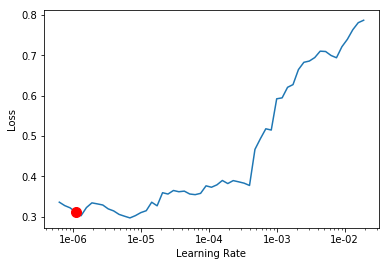

In [21]:
lr_find(learn)
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(1, max_lr=1e-6)

epoch,train_loss,valid_loss,acc_camvid
1,0.369218,0.407146,0.092026


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


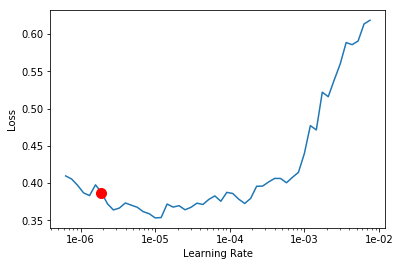

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,acc_camvid
1,0.345394,0.399601,0.099884
2,0.331350,0.392545,0.111468


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


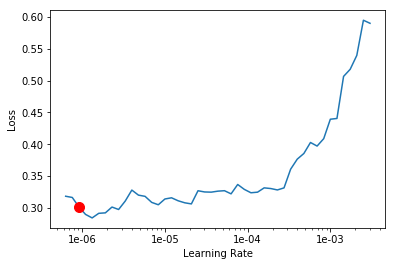

In [25]:
learn.lr_find()
learn.recorder.plot()

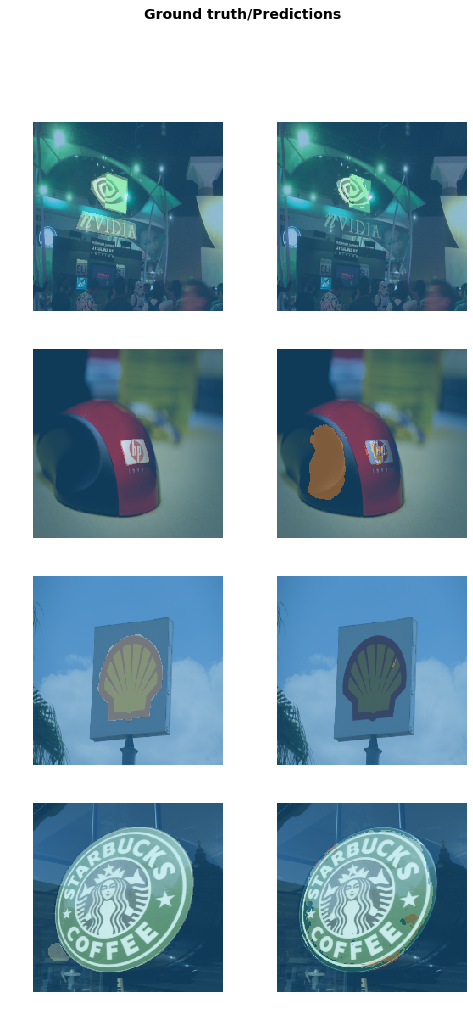

In [27]:
learn.show_results()

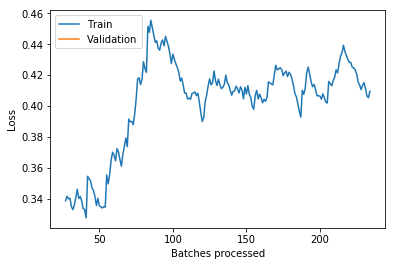

In [28]:
learn.recorder.plot_losses()